In [12]:
# Import libraries
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.models import load_model
import keras
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import requests
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
# Loading the tokenizer to generate tokens and model to perform sentiment analysis
#tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
#model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

In [3]:
# Define the path to save the tokenizer and model
#save_directory = '/Final Year Project/twitter_roberta_sentiment'

# Save the tokenizer and model
#tokenizer.save_pretrained(save_directory)
#model.save_pretrained(save_directory)

In [4]:
# Define the path where the tokenizer and model are saved
load_directory = '/Final Year Project/twitter_roberta_sentiment'

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(load_directory)
model = AutoModelForSequenceClassification.from_pretrained(load_directory)

In [5]:
# Override how Pandas Datareader reads data
yf.pdr_override()

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Define the list of stocks you want to download
stocks = ['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS',
          'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BPCL.NS', 'BHARTIARTL.NS',
          'BRITANNIA.NS', 'CIPLA.NS', 'COALINDIA.NS', 'DIVISLAB.NS', 'DRREDDY.NS',
          'EICHERMOT.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS',
          'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'ITC.NS',
          'INDUSINDBK.NS', 'INFY.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'LTIM.NS', 'LT.NS',
          'M&M.NS', 'MARUTI.NS', 'NTPC.NS', 'NESTLEIND.NS', 'ONGC.NS', 'POWERGRID.NS',
          'RELIANCE.NS', 'SBILIFE.NS', 'SHRIRAMFIN.NS', 'SBIN.NS', 'SUNPHARMA.NS',
          'TCS.NS', 'TATACONSUM.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TECHM.NS',
          'TITAN.NS', 'ULTRACEMCO.NS', 'WIPRO.NS']

# Start date, end date and the stock we want to predict
today = datetime.now()
start = datetime(today.year, today.month-3, today.day)
end = datetime(today.year, today.month, today.day)
print(start)
print(end)

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.
2024-03-10 00:00:00
2024-06-10 00:00:00


In [6]:
# Create an empty DataFrame to hold all the data
all_stock_data = pd.DataFrame()

stock = 'TCS.NS'

# Create an empty DataFrame to hold all the data
all_stock_data = pd.DataFrame()

# Download data from Yahoo Finance
df = yf.download(stock, start=start, end=end)

# Ticker for searching news
stockraw = stock[:-3]

# Getting data using html requests
link = f"https://news.google.com/search?q={stockraw}&hl=en-IN&gl=IN&ceid=IN%3Aen"
req = Request(link, headers={'User-Agent': 'Mozilla/5.0'})
webpage = urlopen(req).read()
soup = BeautifulSoup(webpage, 'html.parser')

# Extract titles and dates
titles = soup.find_all('a', class_='JtKRv')
datetimes = soup.find_all('time', class_='hvbAAd')

# Create lists to store extracted data
dates_list = []
titles_list = []

for title, datetime_tag in zip(titles, datetimes):
    # Remove leading/trailing whitespace from title
    title_text = title.text.strip()
    datetime_str = datetime_tag['datetime']

    # Parse datetime string
    formatted_datetime = datetime.strptime(datetime_str, '%Y-%m-%dT%H:%M:%S%z')

    # Append data to respective lists
    dates_list.append(formatted_datetime.date())
    titles_list.append(title_text)

# Create DataFrame
df2 = pd.DataFrame({'Date': dates_list, 'Headline': titles_list})

# Finding the encodings for each of the headlines found
encoded_headlines = []
for headline in df2['Headline']:
    encoded_headline = tokenizer(headline, padding=True, truncation=True, return_tensors='pt')
    encoded_headlines.append(encoded_headline)

# Finding the sentiment scores of each headline
# Initialize an empty list to store the tweet sentiments
headline_sentiments = []

# Iterate over the encoded tweets
for encoded_headline in encoded_headlines:
    # Pass the encoded tweet to the model
    output = model(**encoded_headline)

    # Extract the scores
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    # Calculate the sentiment score between -1 and 1
    sentiment_score = scores[2] - scores[0]

    # Append the sentiment score to the list
    headline_sentiments.append(sentiment_score)

# Add the tweet sentiments as a new column to the DataFrame
df2['Sentiments'] = headline_sentiments

# Convert 'Date' column to datetime if it's not already
df2['Date'] = pd.to_datetime(df2['Date'])

# Group by 'Date' and calculate the average sentiment for each day
average_sentiments = df2.groupby('Date')['Sentiments'].mean().reset_index()

# Merge the dataframes on the 'Date' column with a left join to keep all rows from df
merged_df = pd.merge(df, average_sentiments, on='Date', how='left')

# Fill missing sentiment scores with 0
merged_df['Sentiments'].fillna(0, inplace=True)

# If you want to ensure that 'Sentiments' column is of numeric type
merged_df['Sentiments'] = pd.to_numeric(merged_df['Sentiments'])

# Isolating features for training
cols = list(merged_df)[1:8]

# Storing all data for scaling
df_for_scaling = merged_df[cols]

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the numerical data
scaled_numerical_data = scaler.fit_transform(df_for_scaling)

# Create a new DataFrame for the scaled data
df_scaled = df_for_scaling.copy()
df_scaled[cols] = scaled_numerical_data

# Add a column for the stock ticker
df_scaled['Stock'] = stock

# Add all data to the following dataframe
all_stock_data = pd.concat([all_stock_data, df_scaled])

print(all_stock_data)

[*********************100%%**********************]  1 of 1 completed
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


        Open      High       Low     Close  Adj Close    Volume  Sentiments  \
0   0.754973  0.800392  0.849701  0.823272   0.814232  0.136925    0.478922   
1   0.819699  0.951349  0.904440  0.950757   0.948238  0.310058    0.478922   
2   0.980107  0.973026  0.922972  0.871877   0.865323  0.190109    0.478922   
3   0.880059  0.941638  0.844577  0.978753   0.977666  0.198323    0.478922   
4   0.956041  0.969103  1.000000  1.000000   1.000000  0.243561    0.478922   
5   1.000000  1.000000  0.898975  0.878260   0.872033  0.059406    0.478922   
6   0.681708  0.614026  0.640649  0.558727   0.536155  0.797956    0.478922   
7   0.555070  0.535557  0.629718  0.547054   0.523886  0.088433    0.478922   
8   0.562931  0.516724  0.608881  0.550793   0.527816  0.289089    0.478922   
9   0.382339  0.378617  0.450043  0.437625   0.408859  0.490865    0.478922   
10  0.339641  0.395684  0.478138  0.376710   0.344828  0.250322    0.478922   
11  0.365842  0.294262  0.406319  0.309958   0.27466

In [7]:
df_for_training = all_stock_data.copy()

df_for_training

,Open,High,Low,Close,Adj Close,Volume,Sentiments,Stock
0,0.754973,0.800392,0.849701,0.823272,0.814232,0.136925,0.478922,TCS.NS
1,0.819699,0.951349,0.904440,0.950757,0.948238,0.310058,0.478922,TCS.NS
2,0.980107,0.973026,0.922972,0.871877,0.865323,0.190109,0.478922,TCS.NS
3,0.880059,0.941638,0.844577,0.978753,0.977666,0.198323,0.478922,TCS.NS
4,0.956041,0.969103,1.000000,1.000000,1.000000,0.243561,0.478922,TCS.NS
5,1.000000,1.000000,0.898975,0.878260,0.872033,0.059406,0.478922,TCS.NS
6,0.681708,0.614026,0.640649,0.558727,0.536155,0.797956,0.478922,TCS.NS
7,0.555070,0.535557,0.629718,0.547054,0.523886,0.088433,0.478922,TCS.NS
8,0.562931,0.516724,0.608881,0.550793,0.527816,0.289089,0.478922,TCS.NS
9,0.382339,0.378617,0.450043,0.437625,0.408859,0.490865,0.478922,TCS.NS


In [8]:
# Convert to DataFrame
df = pd.DataFrame(df_for_training)

# Define all possible categories for the 'Stock' column
all_categories = sorted(stocks)

# Convert the 'Stock' column to a categorical type with the specified categories
df['Stock'] = pd.Categorical(df['Stock'], categories=all_categories)

# One hot encoding using pd.get_dummies
df_encoded = pd.get_dummies(df, columns=['Stock'], dummy_na=False)

cols = list(df_encoded)[7:57]


# Ensure the columns are integer type (0 and 1) instead of boolean
df_encoded[cols] = df_encoded[cols].astype(int)

# Print the one hot encoded DataFrame
print(df_encoded)

        Open      High       Low     Close  Adj Close    Volume  Sentiments  \
0   0.754973  0.800392  0.849701  0.823272   0.814232  0.136925    0.478922   
1   0.819699  0.951349  0.904440  0.950757   0.948238  0.310058    0.478922   
2   0.980107  0.973026  0.922972  0.871877   0.865323  0.190109    0.478922   
3   0.880059  0.941638  0.844577  0.978753   0.977666  0.198323    0.478922   
4   0.956041  0.969103  1.000000  1.000000   1.000000  0.243561    0.478922   
5   1.000000  1.000000  0.898975  0.878260   0.872033  0.059406    0.478922   
6   0.681708  0.614026  0.640649  0.558727   0.536155  0.797956    0.478922   
7   0.555070  0.535557  0.629718  0.547054   0.523886  0.088433    0.478922   
8   0.562931  0.516724  0.608881  0.550793   0.527816  0.289089    0.478922   
9   0.382339  0.378617  0.450043  0.437625   0.408859  0.490865    0.478922   
10  0.339641  0.395684  0.478138  0.376710   0.344828  0.250322    0.478922   
11  0.365842  0.294262  0.406319  0.309958   0.27466

In [9]:
# Function to create sequences
def singleStepSampler(df, window):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window):
		res = []
		for j in range(0, window):
			r = []
			for col in df.columns:
				r.append(df[col][i + j])
			res.append(r)
		xRes.append(res)
		yRes.append(df[['Open', 'Close']].iloc[i + window].values)
	return np.array(xRes), np.array(yRes)

In [10]:
# Dataset splitting
SPLIT = 0.85
(X_test, y_test) = singleStepSampler(df_encoded, 20)
print(X_test.shape)
print(y_test.shape)

(39, 20, 57)
(39, 2)


In [13]:
# Load the model
multivariate_lstm = load_model("/Final Year Project/multivariate_lstm_model2.h5")

# Verify the loaded model
multivariate_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               206400    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 206802 (807.82 KB)
Trainable params: 206802 (807.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2/2 [==============================] - 0s 18ms/step


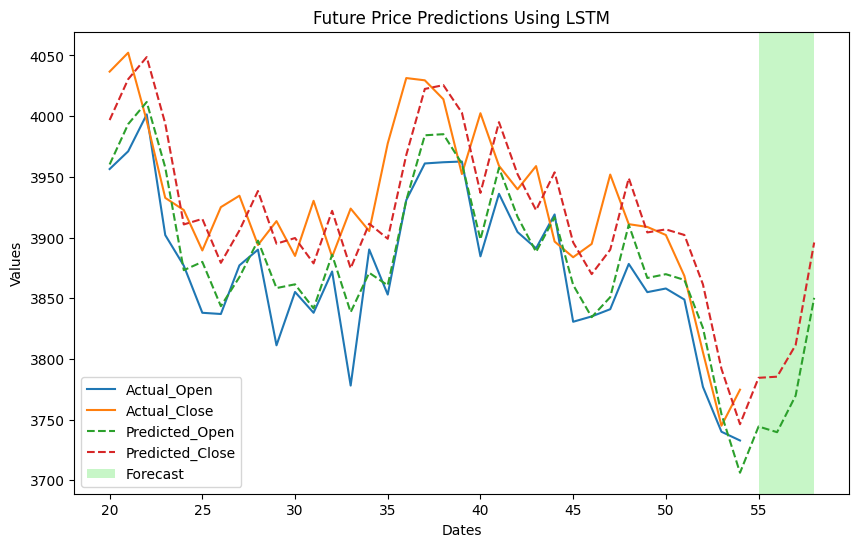

In [19]:
# Reload the data with the date index
dataFrame = merged_df

# Forecast Plot with Dates on X-axis
predicted_values = multivariate_lstm.predict(X_test)

# Array to compensate for inverse transform shape
additional_zeros = np.zeros((len(y_test),5))
additional_zeros_df = pd.DataFrame(additional_zeros)

# Adding zeros to y_test
y_test_extended = np.concatenate((y_test, additional_zeros), axis=1)

# Adding zeros to predicted_values
predicted_values_extended = np.concatenate((predicted_values, additional_zeros), axis=1)

# Inverse transform the data
y_test_inv = scaler.inverse_transform(y_test_extended)
predicted_values_inv = scaler.inverse_transform(predicted_values_extended)

# Create the DataFrame with inverse-transformed data
d = {
    'Predicted_Open': predicted_values_inv[:, 0],
    'Predicted_Close': predicted_values_inv[:, 1],
    'Actual_Open': y_test_inv[:, 0],
    'Actual_Close': y_test_inv[:, 1],
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):]  # Assigning the correct date index

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Highlight the forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1  # Adjusted to stay within bounds

# Plot the actual values
plt.plot(d[['Actual_Open', 'Actual_Close']][:highlight_start], label=['Actual_Open', 'Actual_Close'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_Open', 'Predicted_Close']], label=['Predicted_Open', 'Predicted_Close'], linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('Future Price Predictions Using LSTM')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()

In [20]:
predicted_values_inv[-20:, :2]

array([[3960.88030495, 4002.83717541],
       [3898.41012558, 3936.77245711],
       [3957.41140296, 3995.02936862],
       [3917.10646989, 3952.21509762],
       [3888.14736344, 3922.48624176],
       [3916.653033  , 3953.69528902],
       [3860.96395325, 3895.988455  ],
       [3834.39863855, 3869.8478259 ],
       [3850.88528995, 3889.97255878],
       [3910.47992487, 3948.9017197 ],
       [3866.67132463, 3904.18877062],
       [3869.79681294, 3906.68355715],
       [3865.06455583, 3902.10786769],
       [3825.61277482, 3861.42565779],
       [3754.49932425, 3791.75641958],
       [3706.25420131, 3746.20847204],
       [3744.32304511, 3784.42978057],
       [3739.63544223, 3785.36545465],
       [3769.76240703, 3811.44903879],
       [3850.29822823, 3895.88735401]])